<a href="https://colab.research.google.com/github/LucasBezerraSantos/Projetos_BlueEdtech/blob/main/Projeto_Classificador_multi_r%C3%B3tulo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto - Classificador multi-rótulo - arXiv Paper Abstract
Lucas Bezerra - Ciência de Dados

----
Este projeto tem o objetivo de realizar uma classificação de artigos ciêntificos. São realizados testes com classificação a partir das sinópses, como também, através dos títulos. O objetivo é avaliar qual a entrada de dados mais eficiênte para o treinamento e classificação.


## Leitura dos dados e rotinas de pré-processamento

### Bibliotecas utilizadas

In [ ]:
import re

import numpy as np
import pandas as pd

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import f1_score

In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

True

### Configuração de híperparametros

In [ ]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
mlb = MultiLabelBinarizer()
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
tfidf_transformer = TfidfTransformer()

In [ ]:
imdb_dados = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/arxiv_data_210930-054931.csv')

### Tratamento dos rótulos

✅ Começaremos tratando a coluna "Terms" que representa a **Categoria** de cada artigo ciêntifico. Excluiremos os termos que aparecem em menos de 1% dos casos, para que o algoritmo foque em dados recorrentes e classifique melhor. 

In [ ]:
contagem = imdb_dados.terms.value_counts()

In [ ]:
contagem = imdb_dados.terms.value_counts()
manter = contagem[contagem > 400]
imdb_dados = imdb_dados[imdb_dados.terms.isin(manter.index)]

titulos = imdb_dados.titles
sinopses = imdb_dados.abstracts
generos  = imdb_dados.terms.apply(lambda x : [n.strip() for n in x.split(',')]).tolist()

In [ ]:
# Limpa caracteres especiais da coluna de Terms

termos_limpos = imdb_dados['terms'].apply(lambda x: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", '', x))

In [ ]:
new_imdb_dados = pd.concat( (imdb_dados, termos_limpos), axis=1)
new_imdb_dados = new_imdb_dados.iloc[:,1:4]

✅ Agora vamos converter as categorias em números

In [ ]:
mlb.fit(new_imdb_dados['terms'])
y = mlb.transform(new_imdb_dados['terms'])

In [ ]:
y

array([[0, 0, 0, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 1, 1]])

In [ ]:
# funcao para tratar cada palavra e remover stopwords
def processamento(tokens):
    
    token_processado = []
    for token in tokens:
        token = token.lower()
        token = lemmatizer.lemmatize(token)
        
        if token not in stop_words:
            token = stemmer.stem(token)
            token_processado.append(token)
        
    return token_processado

### Tratamento de "abstacts"

✅ Assim como fizemos com a coluna de **Terms**, também converteremos a coluna de **Abstacts** para valores númericos. Acrescentaremos a remoção de StopWords por ser um conjunto de palavras e faremos a Lematização. Devido ao ganho de informação escolhemos a coluna Abstacts, pois nela tem o contexto de cada artigo ciêntifico e palavras que ajudarão na classificação.

In [ ]:
documentos = []
for sinopse in sinopses:
    
    # expressao regular para remover pontuacoes do texto
    sinopse = re.sub(r'[^\w\s]','', sinopse)
    tokens = processamento(word_tokenize(sinopse))
    
    documentos.append(' '.join(tokens))

X_train_counts = vectorizer.fit_transform(documentos)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X = X_train_tfidf

In [ ]:
X.shape

(40168, 1042681)

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
#Este transformador realiza redução de dimensionalidade linear por meio de decomposição de valor singular truncado (SVD). 
#Ao contrário do PCA, este estimador não centraliza os dados antes de calcular a decomposição do valor singular. 
#Isso significa que ele pode trabalhar com matrizes esparsas de forma eficiente

svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd.fit(X)

TruncatedSVD(n_components=5, n_iter=7, random_state=42)

### Pequena visualização do conteúdo dos textos

In [ ]:
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
ver_sinopse = str(sinopses)

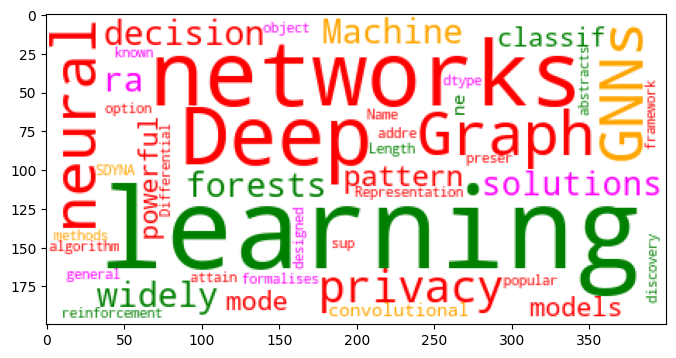

In [ ]:
mapa_cores = ListedColormap(['orange','green','red','magenta'])
nuvem = WordCloud(background_color= 'white', 
                  colormap = mapa_cores,
                  max_words = 100)
nuvem.generate(ver_sinopse)
plt.figure(figsize=(8,6), dpi=100)
plt.imshow(nuvem)

### Tratamento de "Titulo"

✅ Para realizar o tratamento dos Títulos, extraimos todas as pontuações, acentos e caracteres especiais das palavras, como também, retiramos os StopWords e executamos a lematização através da função **Processamento**.

In [ ]:
documentos_titulo = []
for titulo in titulos:
    
    # expressao regular para remover pontuacoes do texto
    titulo = re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?','', titulo)
    tokens_t = processamento(word_tokenize(titulo))
    
    documentos_titulo.append(' '.join(tokens_t))

In [ ]:
documentos_titulo[0]

'multilevel attent pool graph neural network unifi graph represent multipl local'

## Classificação multi rótulos. 
Implementação de 3 classificadores diferentes e comparativo de performances.

### Modelos baseados em Títulos

### ✅ SGDClassifier baseados em Títulos:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
X_train_counts = vectorizer.fit_transform(documentos_titulo)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new = X_train_tfidf

In [ ]:
split_validation = train_test_split(X_new, y, sinopses, test_size=0.20, stratify = y, random_state=10)

(X_train, X_test)             = split_validation[:2]
(y_train, y_test)             = split_validation[2:4]
(titulos_train, titulos_test) = split_validation[4:]

svm = SGDClassifier() 
clf = OneVsRestClassifier(svm)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 11 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 13 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])


In [ ]:
print('Resultado F1: {:.4f}'.format( f1_score(y_test, y_pred, average="micro")))
print('Acurácia', round(accuracy_score(y_test, y_pred), 3))

Resultado F1: 0.8213
Acurácia 0.481


### ✅ Random Forest baseados em Títulos:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
split_validation = train_test_split(X_new, y, sinopses, test_size=0.20, stratify = y, random_state=10)

(X_train, X_test)             = split_validation[:2]
(y_train, y_test)             = split_validation[2:4]
(titulos_train, titulos_test) = split_validation[4:]

floresta = RandomForestClassifier()
floresta.fit(X_train, y_train)
y_pred = floresta.predict(X_test)

In [ ]:
print('Resultado F1: {:.4f}'.format( f1_score(y_test, y_pred, average="micro")))
print('Acurácia', round(accuracy_score(y_test, y_pred), 3))

Resultado F1: 0.8909
Acurácia 0.681


### ✅ KNN baseados em Títulos:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
split_validation = train_test_split(X_new, y, sinopses, test_size=0.20, stratify = y, random_state=10)

(X_train, X_test)             = split_validation[:2]
(y_train, y_test)             = split_validation[2:4]
(titulos_train, titulos_test) = split_validation[4:]

Kvizinhos = KNeighborsClassifier()
Kvizinhos.fit(X_train, y_train)
y_pred = Kvizinhos.predict(X_test)

In [ ]:
print('Resultado F1: {:.4f}'.format( f1_score(y_test, y_pred, average="micro")))
print('Acurácia', round(accuracy_score(y_test, y_pred), 3))

Resultado F1: 0.7979
Acurácia 0.283


### Modelos baseados em Sinopses

### ✅ O Primeiro Modelo aplicado é o SGDClassifier. 

**Sklearn**: Este estimador implementa modelos lineares regularizados com aprendizado estocástico de gradiente descendente (SGD): o gradiente da perda é estimado em cada amostra de cada vez e o modelo é atualizado ao longo do caminho com um cronograma de força decrescente (também conhecido como taxa de aprendizado). O SGD permite o aprendizado em minilote.

In [ ]:
split_validation = train_test_split(X, y, titulos, test_size=0.20, stratify = y, random_state=10)

(X_train, X_test)             = split_validation[:2]
(y_train, y_test)             = split_validation[2:4]
(titulos_train, titulos_test) = split_validation[4:]

svm = SGDClassifier() 
clf = OneVsRestClassifier(svm)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 11 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label 13 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])


In [ ]:
print('Resultado F1: {:.4f}'.format( f1_score(y_test, y_pred, average="micro")))
print('Acurácia', round(accuracy_score(y_test, y_pred), 3))

Resultado F1: 0.8647
Acurácia 0.535


### ✅O segundo Modelo aplicado é o Random Forest.

**Sklearn**: Uma floresta aleatória é um meta estimador que ajusta vários classificadores de árvore de decisão em várias subamostras do conjunto de dados e usa a média para melhorar a precisão preditiva e controlar o ajuste excessivo. O tamanho da subamostra é controlado com o max_samples parâmetro if bootstrap=True(padrão), caso contrário, todo o conjunto de dados é usado para construir cada árvore.

In [ ]:
split_validation = train_test_split(X, y, titulos, test_size=0.20, stratify = y, random_state=10)

(X_train, X_test)             = split_validation[:2]
(y_train, y_test)             = split_validation[2:4]
(titulos_train, titulos_test) = split_validation[4:]

floresta = RandomForestClassifier()
floresta.fit(X_train, y_train)
y_pred = floresta.predict(X_test)

In [ ]:
print('Resultado F1: {:.4f}'.format( f1_score(y_test, y_pred, average="micro")))
print('Acurácia', round(accuracy_score(y_test, y_pred), 3))

Resultado F1: 0.9012
Acurácia 0.73


### ✅O Terceiro Modelo aplicado é o KNN.

Sklearn: Classificador implementando o voto dos k-vizinhos mais próximos.

In [ ]:
split_validation = train_test_split(X, y, titulos, test_size=0.20, stratify = y, random_state=10)

(X_train, X_test)             = split_validation[:2]
(y_train, y_test)             = split_validation[2:4]
(titulos_train, titulos_test) = split_validation[4:]

Kvizinhos = KNeighborsClassifier()
Kvizinhos.fit(X_train, y_train)
y_pred = Kvizinhos.predict(X_test)

In [ ]:
print('Resultado F1: {:.4f}'.format( f1_score(y_test, y_pred, average="micro")))
print('Acurácia', round(accuracy_score(y_test, y_pred), 3))

Resultado F1: 0.8472
Acurácia 0.537


## Comparativo de resultados obtidos. Qual atributo é mais discriminativo.

✅ **RESULTADOS:**

**Modelos baseados em Títulos:**

**SGDClassifier**: F1: 0.8213 | Acurácia 0.481


**Random Forest**: F1: 0.8909 | Acurácia 0.681


**KNN**: F1: 0.7979 | Acurácia 0.283


.

**Modelos baseados em Sinopses:**

**SGDClassifier**: F1: 0.8647 | Acurácia 0.535



**Random Forest**: F1: 0.9012 | Acurácia 0.73



**KNN**: F1: 0.8472 | Acurácia 0.537

**Resposta**: Como esperado, os modelos baseados em Sinopses possuem resultados melhores, pois são treinados com dados que possuem maior ganho de informação sobre o conteúdo a ser classificado em cada Categoria de Artigo Ciêntifico.